In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§Ïπò
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install catboost
    !pip install PDPbox
    !pip install shap

In [ ]:
# ÌïÑÏöî ÎùºÏù¥Î∏åÎü¨Î¶¨ Í∞ÄÏ†∏Ïò§Í∏∞
import numpy as np
import pandas as pd
import pandas_profiling

import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.cluster import KMeans

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


import eli5
from eli5.sklearn import PermutationImportance

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

import shap

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')
sns.set(font_scale=0.8)

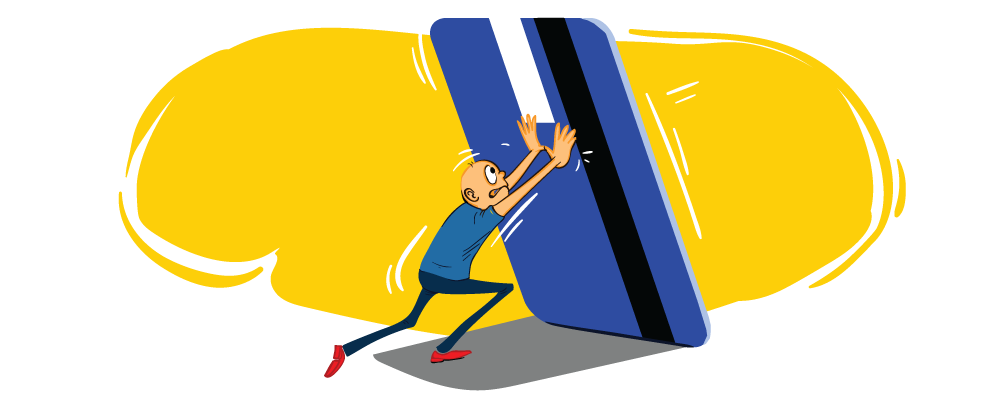

## **Ïã†Ïö©Ïπ¥Îìú ÏÇ¨Ïö©Ïûê Ïó∞Ï≤¥ ÏòàÏ∏° Project**
*   Ïã†Ïö©Ïπ¥ÎìúÏÇ¨Îäî Ïã†Ïö©Ïπ¥Îìú Ïã†Ï≤≠ÏûêÍ∞Ä Ï†úÏ∂úÌïú Í∞úÏù∏Ï†ïÎ≥¥ÏôÄ Îç∞Ïù¥ÌÑ∞Î•º ÌôúÏö©Ìï¥ Ïã†Ïö© Ï†êÏàòÎ•º ÏÇ∞Ï†ïÌï©ÎãàÎã§. Ïã†Ïö©Ïπ¥ÎìúÏÇ¨Îäî Ïù¥ Ïã†Ïö© Ï†êÏàòÎ•º ÌôúÏö©Ìï¥ Ïã†Ï≤≠ÏûêÏùò Ìñ•ÌõÑ Ï±ÑÎ¨¥ Î∂àÏù¥ÌñâÍ≥º Ïã†Ïö©Ïπ¥Îìú ÎåÄÍ∏â Ïó∞Ï≤¥ Í∞ÄÎä•ÏÑ±ÏùÑ ÏòàÏ∏°Ìï©ÎãàÎã§.
*   Ïó∞Ï≤¥ Í∞ÄÎä•ÏÑ± ÏòàÏ∏°ÏùÑ ÌÜµÌï¥ Í∞úÏù∏Ï†ïÎ≥¥ Ï§ë Ïì∏Î™®ÏûàÎäî Îç∞Ïù¥ÌÑ∞ÏôÄ Ïì∏Î™® ÏóÜÎäî Îç∞Ïù¥ÌÑ∞Î•º Íµ¨Î∂ÑÌïòÍ≥† Ìñ•ÌõÑ Ïó∞Ï≤¥Î•º Ìï† Í≤É Í∞ôÏùÄ Í≥†Í∞ùÏóêÍ≤å ÎåÄÏ∂úÌïúÎèÑÎ•º Ï†úÌïúÌïòÎäî Îì± Ïó¨Îü¨ Ï†úÏïàÏùÑ Ìï† Ïàò ÏûàÏùÑ Í≤ÉÏûÖÎãàÎã§.
*   Ïã†Ïö© Îì±Í∏â(credit)Î•º 0, 1, 2Ï†êÏúºÎ°ú Î∂ÑÎ•òÌïòÎäî Îã§Ìï≠Î∂ÑÎ•òÎ™®Îç∏ÏùÑ ÏÇ¨Ïö©Ìï† ÏòàÏ†ïÏûÖÎãàÎã§.




### **Îç∞Ïù¥ÌÑ∞ Î≥ÄÏàò ÏÑ§Î™Ö**


- index

- gender: ÏÑ±Î≥Ñ
- car: Ï∞®Îüâ ÏÜåÏú† Ïó¨Î∂Ä
- reality: Î∂ÄÎèôÏÇ∞ ÏÜåÏú† Ïó¨Î∂Ä
- child_num: ÏûêÎÖÄ Ïàò
- income_total: Ïó∞Í∞Ñ ÏÜåÎìù
- income_type: ÏÜåÎìù Î∂ÑÎ•ò
- edu_type: ÍµêÏú° ÏàòÏ§Ä
- family_type: Í≤∞Ìòº Ïó¨Î∂Ä
- house_type: ÏÉùÌôú Î∞©Ïãù
- DAYS_BIRTH: Ï∂úÏÉùÏùº
> Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÎãπÏãú (0)Î∂ÄÌÑ∞ Ïó≠ÏúºÎ°ú ÏÖà, Ï¶â, -1ÏùÄ Îç∞Ïù¥ÌÑ∞ ÏàòÏßëÏùº ÌïòÎ£® Ï†ÑÏóê ÌÉúÏñ¥ÎÇ¨ÏùåÏùÑ ÏùòÎØ∏
- DAYS_EMPLOYED: ÏóÖÎ¨¥ ÏãúÏûëÏùº
> Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÎãπÏãú (0)Î∂ÄÌÑ∞ Ïó≠ÏúºÎ°ú ÏÖà, Ï¶â, -1ÏùÄ Îç∞Ïù¥ÌÑ∞ ÏàòÏßëÏùº ÌïòÎ£® Ï†ÑÎ∂ÄÌÑ∞ ÏùºÏùÑ ÏãúÏûëÌï®ÏùÑ ÏùòÎØ∏, ÏñëÏàò Í∞íÏùÄ Í≥†Ïö©ÎêòÏßÄ ÏïäÏùÄ ÏÉÅÌÉúÎ•º ÏùòÎØ∏Ìï®
- FLAG_MOBIL: Ìï∏ÎìúÌè∞ ÏÜåÏú† Ïó¨Î∂Ä
- work_phone: ÏóÖÎ¨¥Ïö© Ï†ÑÌôî ÏÜåÏú† Ïó¨Î∂Ä
- phone: Ï†ÑÌôî ÏÜåÏú† Ïó¨Î∂Ä
- email: Ïù¥Î©îÏùº ÏÜåÏú† Ïó¨Î∂Ä
- occyp_type: ÏßÅÏóÖ Ïú†Ìòï													
- family_size: Í∞ÄÏ°± Í∑úÎ™®
- begin_month: Ïã†Ïö©Ïπ¥Îìú Î∞úÍ∏â Ïõî
> Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÎãπÏãú (0)Î∂ÄÌÑ∞ Ïó≠ÏúºÎ°ú ÏÖà, Ï¶â, -1ÏùÄ Îç∞Ïù¥ÌÑ∞ ÏàòÏßëÏùº Ìïú Îã¨ Ï†ÑÏóê Ïã†Ïö©Ïπ¥ÎìúÎ•º Î∞úÍ∏âÌï®ÏùÑ ÏùòÎØ∏


- **credit(ÌÉÄÍ≤ü Î≥ÄÏàò): ÏÇ¨Ïö©ÏûêÏùò Ïã†Ïö©Ïπ¥Îìú ÎåÄÍ∏à Ïó∞Ï≤¥Î•º Í∏∞Ï§ÄÏúºÎ°ú Ìïú Ïã†Ïö©ÎèÑ
   ==> ÎÇÆÏùÑ ÏàòÎ°ù ÎÜíÏùÄ Ïã†Ïö©Ïùò Ïã†Ïö©Ïπ¥Îìú ÏÇ¨Ïö©ÏûêÎ•º ÏùòÎØ∏Ìï©ÎãàÎã§.**

## **Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏**

In [ ]:
# Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏòµÎãàÎã§. ÎåÄÌöåÏö© Îç∞Ïù¥ÌÑ∞Îùº submission ÌååÏùºÏùÄ Î∂àÎü¨Ïò§ÏßÄ ÏïäÏäµÎãàÎã§.

train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test.csv")
# sample_submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sample_submission.csv")

In [ ]:
train.head(2)

index gender car reality  ...  occyp_type  family_size begin_month credit
0      0      F   N       N  ...         NaN          2.0        -6.0    1.0
1      1      F   N       Y  ...    Laborers          3.0        -5.0    1.0

[2 rows x 20 columns]

In [ ]:
# index ÏπºÎüºÍ≥º valueÍ∞Ä ÌïòÎÇò Î∞ñÏóê ÏóÜÎäî FLAG_MOBIL ÏπºÎüº Ï†úÍ±∞
train = train.drop(['index', 'FLAG_MOBIL'], axis=1)
test = test.drop(['index', 'FLAG_MOBIL'], axis=1)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  occyp_type     18286 non-null  object 
 15  family_size    26457 non-null  float64
 16  begin_month    26457 non-null  float64
 17  credit         26457 non-null  float64
dtypes: flo

In [ ]:
train.describe().T

count           mean  ...       75%        max
child_num      26457.0       0.428658  ...       1.0       19.0
income_total   26457.0  187306.524493  ...  225000.0  1575000.0
DAYS_BIRTH     26457.0  -15958.053899  ...  -12446.0    -7705.0
DAYS_EMPLOYED  26457.0   59068.750728  ...    -407.0   365243.0
work_phone     26457.0       0.224742  ...       0.0        1.0
phone          26457.0       0.294251  ...       1.0        1.0
email          26457.0       0.091280  ...       0.0        1.0
family_size    26457.0       2.196848  ...       3.0       20.0
begin_month    26457.0     -26.123294  ...     -12.0        0.0
credit         26457.0       1.519560  ...       2.0        2.0

[10 rows x 8 columns]

In [ ]:
train.shape, test.shape

# testÏóêÎäî credit columnsÏù¥ Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏùåÏùÑ ÌôïÏù∏

((26457, 18), (10000, 17))

In [ ]:
# Í≤∞Ï∏°Ïπò ÌôïÏù∏
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [ ]:
test.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

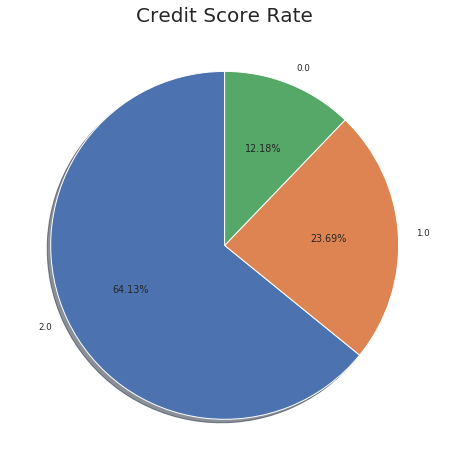

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64


In [ ]:
target = 'credit'


plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('Credit Score Rate', size=20)
plt.show()
print(train[target].value_counts())

üí≥ Ïù¥Î≤à ÌîÑÎ°úÏ†ùÌä∏ÏóêÏÑúÎäî Í≥†Í∞ùÏùò Ïã†Ïö© Îì±Í∏âÏùÑ ÏòàÏ∏°ÌïòÎäî Î™®Îç∏ÏùÑ ÎßåÎìúÎäî Í≤ÉÏù¥ Î™©ÌëúÏù¥ÎØÄÎ°ú '**credit**'ÏùÑ ÌÉÄÍ≤ü ÌäπÏÑ±ÏúºÎ°ú ÏÑ§Ï†ïÌï©ÎãàÎã§. 

ÏúÑ Í∑∏ÎûòÌîÑÏóê Î≥¥Ïù¥Îäî Í≤ÉÏ≤òÎüº 0Ï†ê, 1Ï†ê, 2Ï†êÏúºÎ°ú Î∂ÑÎ•ò ÎêòÎäîÎç∞ 2Ï†ê(Ïã†Ïö©Îì±Í∏âÏù¥ ÏïàÏ¢ãÏùÄ)Ïùò Î∂ÑÌè¨Í∞Ä ÎßéÏùåÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.


Î™®Îç∏Í≥º ÌèâÍ∞ÄÏßÄÌëúÎäî Í∞ÅÍ∞Å CatboostÍ≥º Log LossÎ•º ÏÇ¨Ïö©Ìï† ÏòàÏ†ïÏù∏Îç∞, Ïù¥Ïú†Îäî ÏïÑÎûòÍ≥º Í∞ôÏäµÎãàÎã§.

#### **Catboost**
- Category featuresÎ•º ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî One-Hot-EncodingÎì± Îç∞Ïù¥ÌÑ∞Î•º Ï†ÑÏ≤òÎ¶¨Ìï† ÌïÑÏöîÍ∞Ä ÏûàÏóàÏßÄÎßå CatboostÏóêÏÑúÎäî ÏÇ¨Ïö©ÏûêÍ∞Ä Îã§Î•∏ ÏûëÏóÖÏùÑ ÌïòÏßÄ ÏïäÏïÑÎèÑ ÏûêÎèôÏúºÎ°ú Ïù¥Î•º Î≥ÄÌôòÌïòÏó¨ ÏÇ¨Ïö©Ìï©ÎãàÎã§..

- Ï†ÅÏùÄ Îç∞Ïù¥ÌÑ∞Î°úÎèÑ Ï¢ãÏùÄ Í≤∞Í≥ºÎ•º ÏñªÏùÑ Ïàò ÏûàÎäî Ìö®Ïú®Ï†ÅÏù∏ Î∞©Î≤ïÏûÖÎãàÎã§.
- ÌïôÏäµ ÏãúÍ∞ÑÏù¥ Îã§Î•∏ GBDTÏóê Î≥¥Îã§Îäî Îçî Ïò§Îûò Í±∏Î¶¨Îäî ÎåÄÏã†Ïóê ÏòàÏ∏° ÏãúÍ∞ÑÏù¥ 13-16Î∞∞ Ï†ïÎèÑ Îçî Îπ†Î•¥Îã§Í≥† Ìï©ÎãàÎã§.

#### **Log Loss**
- ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú ÎßûÏ∂ò Í≤∞Í≥ºÎßå Í∞ÄÏßÄÍ≥† ÏÑ±Îä•ÏùÑ ÌèâÍ∞ÄÌï† Í≤ΩÏö∞, ÏñºÎßåÌÅºÏùò ÌôïÎ•†Î°ú Ìï¥Îãπ ÎãµÏùÑ ÏñªÏùÄÍ±¥ÏßÄ ÌèâÍ∞ÄÍ∞Ä Î∂àÍ∞ÄÎä•Ìï©ÎãàÎã§.. ÎãµÏùÄ ÎßûÏ∑ÑÏßÄÎßå 20%Ïùò ÌôïÎ•†Î°ú Í∑∏Ï†Ä Ï∞çÏùÄÍ±∞ÎùºÎ©¥ ÏÑ±Îä•Ïù¥ Ï¢ãÏùÄ Î™®Îç∏Ïù¥ÎùºÍ≥† Ìï† Ïàò ÏóÜÏäµÎãàÎã§.

- Ïù¥Î•º Î≥¥ÏôÑÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî ÌôïÎ•† Í∞íÏùÑ ÌèâÍ∞Ä ÏßÄÌëúÎ°ú ÏÇ¨Ïö©ÌïòÎ©¥ Îê©ÎãàÎã§. Log lossÎäî Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú ÌôïÎ•† Í∞íÏùÑ ÏßÅÏ†ëÏ†ÅÏúºÎ°ú Î∞òÏòÅÌïòÏó¨ ÌèâÍ∞ÄÌï©ÎãàÎã§.
- ÌôïÎ•† Í∞íÏùÑ ÏùåÏùò logÌï®ÏàòÏóê ÎÑ£Ïñ¥ Î≥ÄÌôòÏùÑ ÏãúÌÇ® Í∞íÏúºÎ°ú ÌèâÍ∞ÄÌïòÎäîÎç∞, Ïù¥Îäî ÏûòÎ™ª ÏòàÏ∏°Ìï† ÏàòÎ°ù, Ìå®ÎÑêÌã∞Î•º Î∂ÄÏó¨ÌïòÍ∏∞ ÏúÑÌï®ÏûÖÎãàÎã§.

[Catboost Ï£ºÏöî Í∞úÎÖêÍ≥º ÌäπÏßï](https://dailyheumsi.tistory.com/136)

## **Categorical Variable EDA**

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ Ï∞®Ïù¥Î•º Î≥¥Í∏∞ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ•ò
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]

In [ ]:
# Categorical Í∑∏ÎûòÌîÑ Ìï®Ïàò Ï†ïÏùò
def cat_plot(column):

  f, ax = plt.subplots(1, 3, figsize=(16, 4))


  sns.countplot(x = column,
                data = train_0,
                ax = ax[0],
                order = train_0[column].value_counts().index)
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit = 0')
  ax[0].set_ylabel('count')
  ax[0].tick_params(rotation=50)


  sns.countplot(x = column,
                data = train_1,
                ax = ax[1],
                order = train_1[column].value_counts().index)
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit = 1')
  ax[1].set_ylabel('count')
  ax[1].tick_params(rotation=50)

  sns.countplot(x = column,
                data = train_2,
                ax = ax[2],
                order = train_2[column].value_counts().index)
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit = 2')
  ax[2].set_ylabel('count')
  ax[2].tick_params(rotation=50)
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

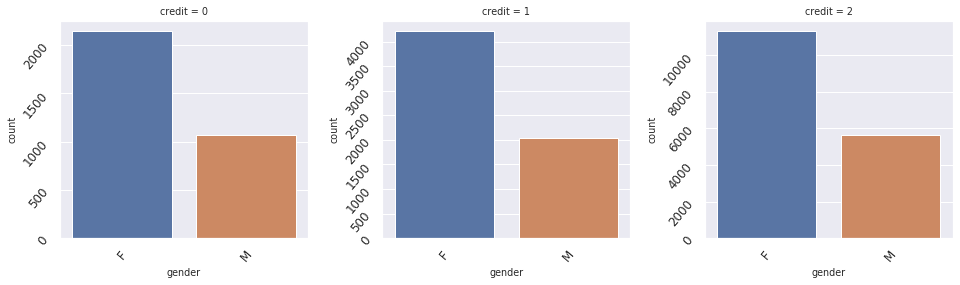

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ ÏÑ±Î≥ÑÏ∞®Ïù¥ ÌôïÏù∏ >> Î™®Îì† Îì±Í∏âÏóêÏÑú ÎÇ®ÏÑ±Ïù¥ Îçî ÎßéÏùå.
cat_plot("gender")

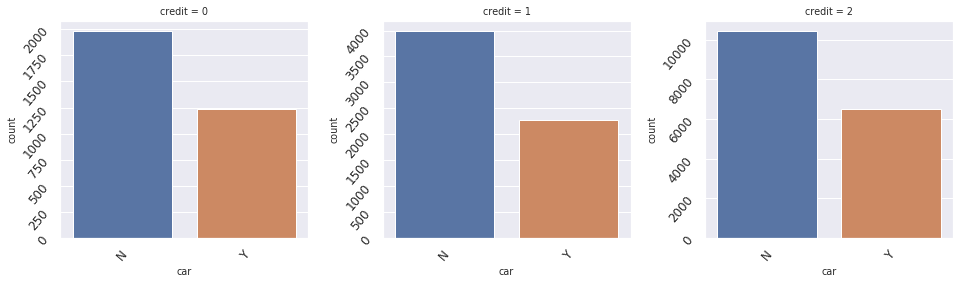

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ Ï∞®ÏÜåÏú†Ïó¨Î∂Ä ÌôïÏù∏ >> Î™®Îì† Îì±Í∏âÏóêÏÑú Ï∞®Í∞Ä ÏóÜÎäî ÏÇ¨ÎûåÏù¥ Îçî ÎßéÏùå
cat_plot("car")

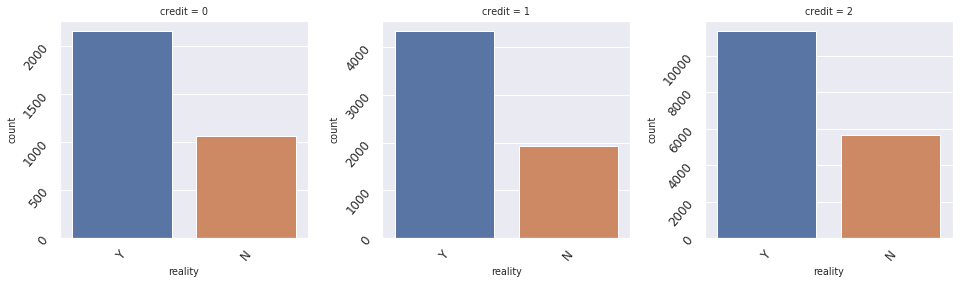

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ Î∂ÄÎèôÏÇ∞ÏÜåÏú†Ïó¨Î∂Ä ÌôïÏù∏ >> Î™®Îì† Îì±Í∏âÏóêÏÑú Î∂ÄÎèôÏÇ∞Ïù¥ ÏóÜÎäî ÏÇ¨ÎûåÏù¥ Îçî ÎßéÏùå
cat_plot("reality")

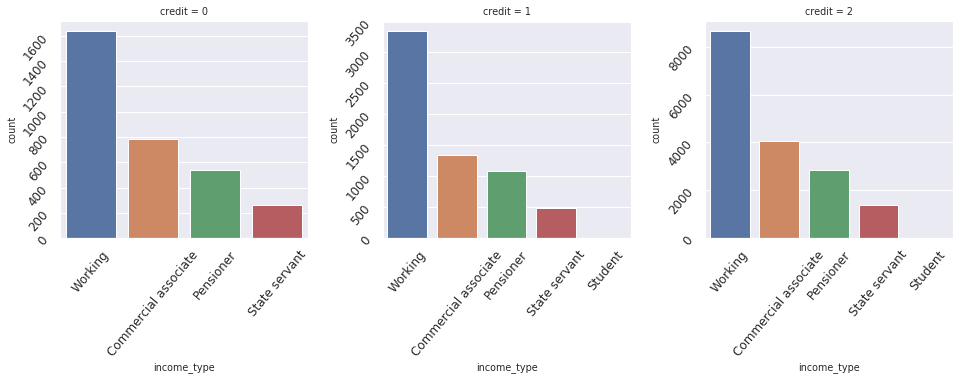

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ ÏÜåÎìù Î∂ÑÎ•òÏùò Ï∞®Ïù¥ ÌôïÏù∏ >> Î™®Îì† Îì±Í∏âÏóêÏÑú Í∑ºÎ°úÏÜåÎìùÏûêÍ∞Ä Í∞ÄÏû• ÎßéÏùå
cat_plot("income_type")

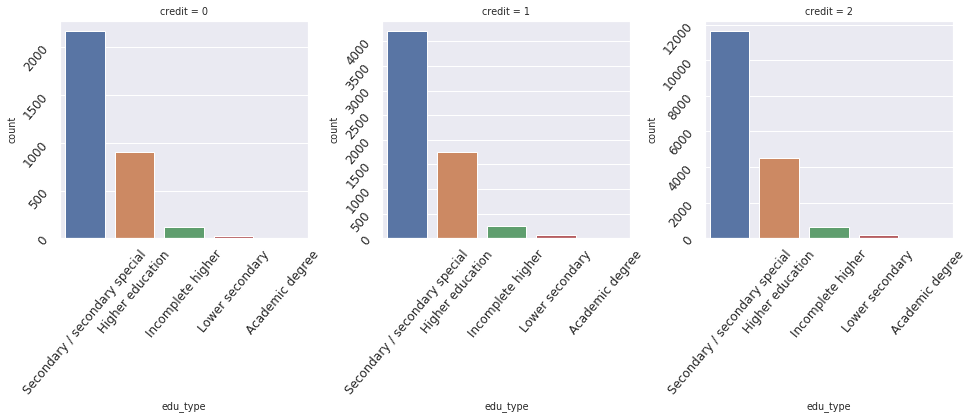

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ ÍµêÏú° ÏàòÏ§Ä Ï∞®Ïù¥ ÌôïÏù∏ > Î™®Îì† Îì±Í∏âÏóêÏÑú SecondaryÍ∞Ä Í∞ÄÏû• ÎßéÍ≥†, Í∑∏ Îã§ÏùåÏúºÎ°ú HigherÏù¥ ÎßéÏùå.
cat_plot("edu_type")

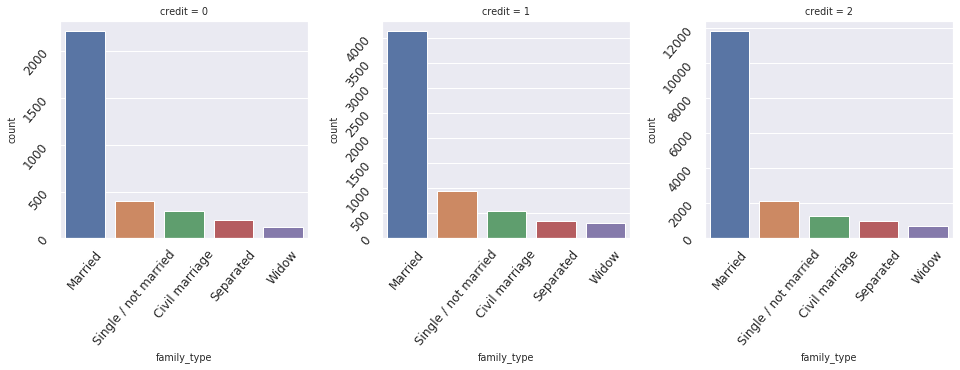

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ Í≤∞Ìòº ÌòïÌÉúÏùò Ï∞®Ïù¥ ÌôïÏù∏ > Î™®Îì† Îì±Í∏âÏóêÏÑú Í≤∞ÌòºÌïú ÎπÑÏú®Ïù¥ Í∞ÄÏû• ÎßéÏùå.
cat_plot("family_type")

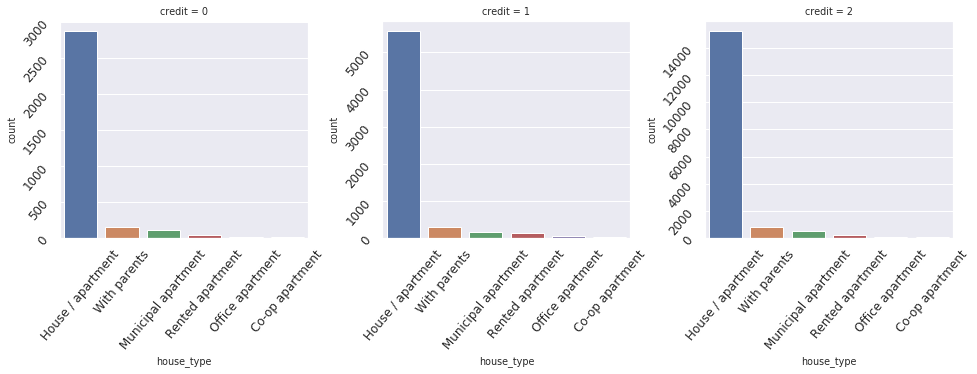

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ ÏûêÍ∞Ä ÌòïÌÉúÏùò Ï∞®Ïù¥ ÌôïÏù∏ > Î™®Îì† Îì±Í∏âÏóêÏÑú House/apartmentÍ∞Ä Í∞ÄÏû• ÎßéÏùå.
cat_plot("house_type")

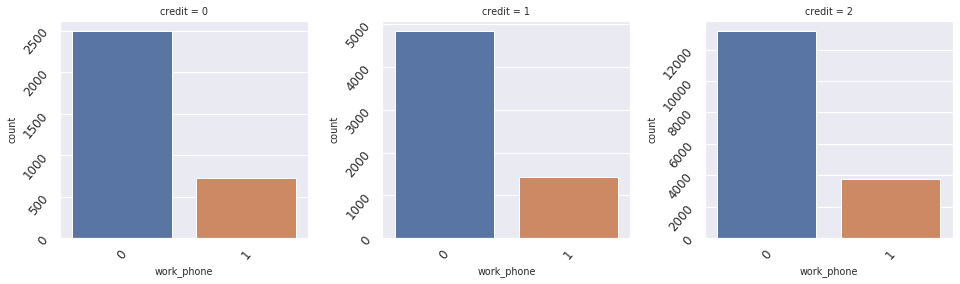

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ ÏóÖÎ¨¥Ïö© Ìï∏ÎìúÌè∞ ÏÜåÏú†Ïó¨Î∂ÄÏùò Ï∞®Ïù¥ ÌôïÏù∏ > Î™®Îì† Îì±Í∏âÏóêÏÑú ÏóÖÎ¨¥Ïö© Ìï∏ÎìúÌè∞ÏùÑ ÏÜåÏú†ÌïòÏßÄ ÏïäÏùÄ ÎπÑÏú®Ïù¥ Îçî ÎßéÏùå
cat_plot("work_phone")

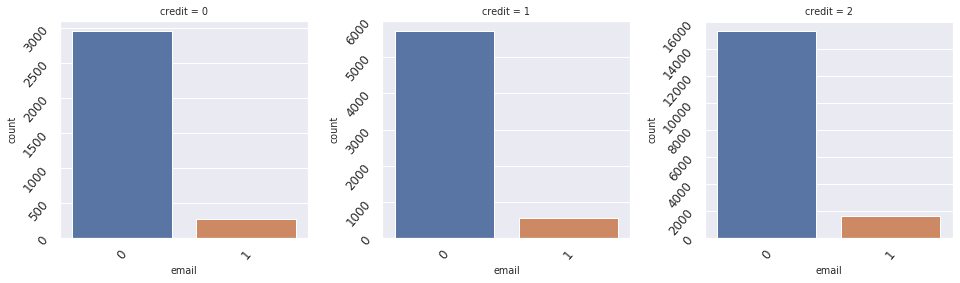

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ Ïù¥Î©îÏùº ÏÜåÏú†Ïó¨Î∂ÄÏùò Ï∞®Ïù¥ ÌôïÏù∏ > Î™®Îì† Îì±Í∏âÏóêÏÑú Ïù¥Î©îÏùºÏùÑ Í∞ñÍ≥† ÏûàÎäî ÏÇ¨ÎûåÏù¥ ÎßéÏùå.
cat_plot("email")

In [ ]:
# 'ouccyp_type'ÏπºÎüºÏùò Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
train_0 = train_0.fillna({'occyp_type':'untitled'})
train_1 = train_1.fillna({'occyp_type':'untitled'})
train_2 = train_2.fillna({'occyp_type':'untitled'})

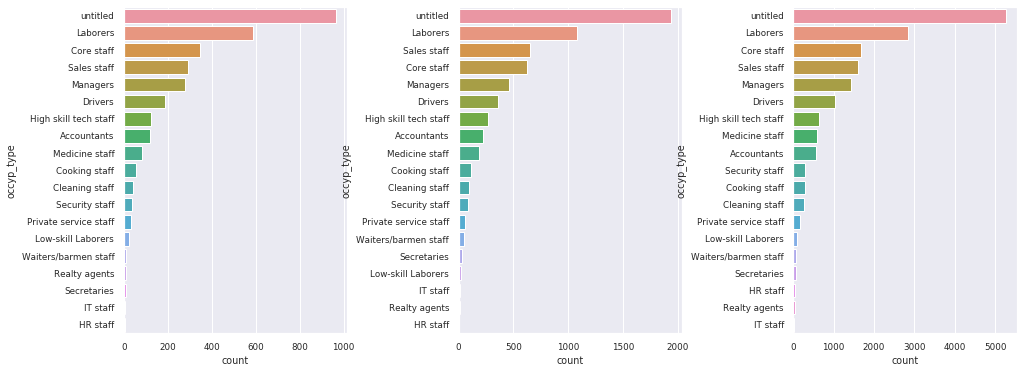

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ ÏßÅÏóÖÏú†Ìòï Ï∞®Ïù¥ ÌôïÏù∏ >> Î™®Îì† Îì±Í∏âÏóêÏÑú  untitle > Laborers > Staff ÏàúÏúºÎ°ú Î∂ÑÌè¨Í∞Ä ÌòïÏÑ±Îê®ÏùÑ ÌôïÏù∏

f, ax = plt.subplots(1, 3, figsize=(16, 6))
sns.countplot(y = 'occyp_type', data = train_0, order = train_0['occyp_type'].value_counts().index, ax=ax[0])
sns.countplot(y = 'occyp_type', data = train_1, order = train_1['occyp_type'].value_counts().index, ax=ax[1])
sns.countplot(y = 'occyp_type', data = train_2, order = train_2['occyp_type'].value_counts().index, ax=ax[2])
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

## **Numerical Variable EDA**
ÌïúÎààÏóê ÌååÏïÖÌïòÍ∏∞ ÏúÑÌï¥ Í∑∏ÎûòÌîÑÎ•º Í≤πÏ≥êÏÑú ÏßÑÌñâ

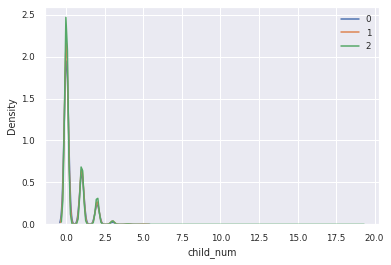

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ ÏûêÎÖÄ Ïàò Ï∞®Ïù¥ ÌôïÏù∏ >> Î™®Îì† Îì±Í∏âÏóê ÏïÑÏù¥ ÏàòÍ∞Ä 0Î™ÖÏù¥ Í∞ÄÏû• ÎÜíÏùå.

sns.distplot(train_0['child_num'],label='0', hist=False)
sns.distplot(train_1['child_num'],label='1', hist=False)
sns.distplot(train_2['child_num'],label='2', hist=False)
plt.legend()

In [ ]:
train.describe().T

count           mean  ...       75%        max
child_num      26457.0       0.428658  ...       1.0       19.0
income_total   26457.0  187306.524493  ...  225000.0  1575000.0
DAYS_BIRTH     26457.0  -15958.053899  ...  -12446.0    -7705.0
DAYS_EMPLOYED  26457.0   59068.750728  ...    -407.0   365243.0
work_phone     26457.0       0.224742  ...       0.0        1.0
phone          26457.0       0.294251  ...       1.0        1.0
email          26457.0       0.091280  ...       0.0        1.0
family_size    26457.0       2.196848  ...       3.0       20.0
begin_month    26457.0     -26.123294  ...     -12.0        0.0
credit         26457.0       1.519560  ...       2.0        2.0

[10 rows x 8 columns]

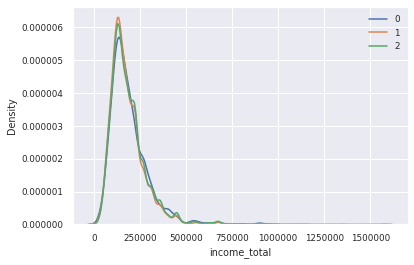

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ Ïó∞Í∞Ñ ÏÜåÎìùÏùò Ï∞®Ïù¥ ÌôïÏù∏ >> Î™®Îì† Îì±Í∏âÏóêÏÑú ÏïΩ 180000Ï†ïÎèÑÍ∞Ä Í∞ÄÏû• ÎÜíÏùå.

sns.distplot(train_0['income_total'],label='0', hist=False)
sns.distplot(train_1['income_total'],label='1', hist=False)
sns.distplot(train_2['income_total'],label='2', hist=False)
plt.legend()

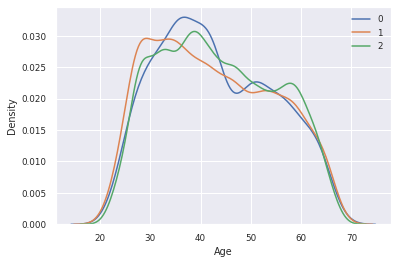

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ ÎÇòÏù¥ Ï∞®Ïù¥ ÌôïÏù∏ >> Îì±Í∏âÎ≥ÑÎ°ú ÏïΩÍ∞ÑÏùò Ï∞®Ïù¥Í∞Ä ÏûàÏßÄÎßå 20ÎåÄ ÌõÑÎ∞òÎ∂ÄÌÑ∞ 40ÎåÄ Ï¥àÎ∞òÍπåÏßÄÍ∞Ä Î™®Îì† Îì±Í∏âÏóêÏÑú Í∞ÄÏû• ÎÜíÏùå

train_0['Age'] = abs(train_0['DAYS_BIRTH'])/365
train_1['Age'] = abs(train_1['DAYS_BIRTH'])/365
train_2['Age'] = abs(train_2['DAYS_BIRTH'])/365

train_0 = train_0.astype({'Age': 'int'})
train_1 = train_1.astype({'Age': 'int'})
train_2 = train_2.astype({'Age': 'int'})

sns.distplot(train_0['Age'],label='0', hist=False)
sns.distplot(train_1['Age'],label='1', hist=False)
sns.distplot(train_2['Age'],label='2', hist=False)
plt.legend()

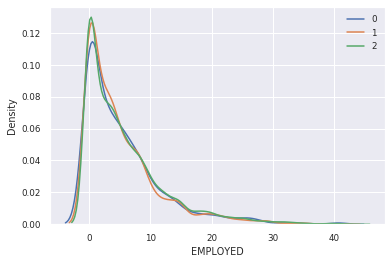

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ Í≥†Ïö©Ïùº Ï∞®Ïù¥ ÌôïÏù∏ >> Î™®Îì† Îì±Í∏âÏóêÏÑú Î¨¥ÏßÅÏûêÏùò ÎπÑÏú®Ïù¥ Í∞ÄÏû• ÎßéÍ≥† ÏùºÏùÑ ÌïúÏßÄ 10ÎÖÑÏù¥ ÎÑòÏñ¥Í∞ÄÎ©¥ ÎπÑÏú®Ïù¥ ÎßéÏù¥ Ï§ÑÏñ¥Îì¨.
# ÏñëÏàòÎäî Í≥†Ïö©ÎêòÏßÄ ÏïäÏùÄ ÏÉÅÌÉúÎ°ú Î¨¥ÏßÅÏùÑ ÏùòÎØ∏ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê 0ÏúºÎ°ú ÎåÄÏ≤¥

train_0['EMPLOYED']= train_0['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train_1['EMPLOYED']= train_1['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train_2['EMPLOYED']= train_2['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)

train_0['EMPLOYED'] = abs(train_0['EMPLOYED'])/365
train_1['EMPLOYED'] = abs(train_1['EMPLOYED'])/365
train_2['EMPLOYED'] = abs(train_2['EMPLOYED'])/365

train_0 = train_0.astype({'EMPLOYED': 'int'})
train_1 = train_1.astype({'EMPLOYED': 'int'})
train_2 = train_2.astype({'EMPLOYED': 'int'})

sns.distplot(train_0['EMPLOYED'],label='0', hist=False)
sns.distplot(train_1['EMPLOYED'],label='1', hist=False)
sns.distplot(train_2['EMPLOYED'],label='2', hist=False)
plt.legend()

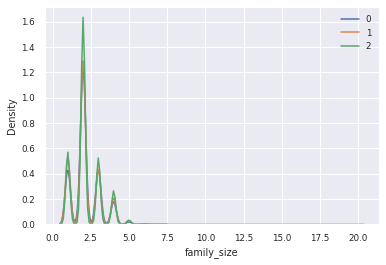

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ Í∞ÄÏ°± Í∑úÎ™® Ï∞®Ïù¥ ÌôïÏù∏ >> Î™®Îì† Îì±Í∏âÏóêÏÑú 2Î™ÖÏùò ÎπÑÏú®Ïù¥ Í∞ÄÏû• ÎßéÏùå. ÏúÑÏùò Îç∞Ïù¥ÌÑ∞ Ï§ë Í≤∞ÌòºÌïú ÎπÑÏú®Ïù¥ ÎßéÍ≥†, ÏïÑÏù¥ ÏàòÍ∞Ä 0Ïù∏ Í≤ΩÏö∞Í∞Ä ÎßéÏùÄ Í≤ÉÍ≥º ÏùºÎß•ÏÉÅÌÜµÌï®

sns.distplot(train_0['family_size'],label='0', hist=False)
sns.distplot(train_1['family_size'],label='1', hist=False)
sns.distplot(train_2['family_size'],label='2', hist=False)
plt.legend()

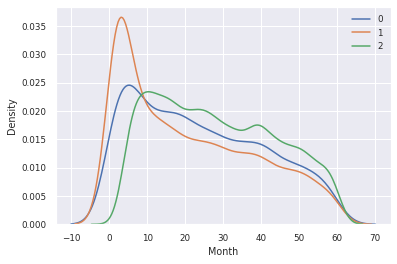

In [ ]:
# Ïã†Ïö©Îì±Í∏âÏóê Îî∞Î•∏ Ïã†Ïö©Ïπ¥Îìú Î∞úÍ∏âÍ∏∞Í∞Ñ(Ïõî) Ï∞®Ïù¥ ÌôïÏù∏ >>  Î™®Îì† Îì±Í∏âÏóêÏÑú 10Í∞úÏõîÍπåÏßÄÏùò Î∞úÍ∏âÍ∏∞Í∞Ñ ÎπÑÏú®Ïù¥ Í∞ÄÏû• ÎÜíÏïòÍ≥† Í∑∏ Îí§Î°úÎäî Î∞úÍ∏âÍ∏∞Í∞ÑÏù¥ Ï†êÏ†ê Ï§ÑÏñ¥Îì¨

train_0['Month'] = abs(train_0['begin_month'])
train_1['Month'] = abs(train_1['begin_month'])
train_2['Month'] = abs(train_2['begin_month'])

train_0 = train_0.astype({'Month': 'int'})
train_1 = train_1.astype({'Month': 'int'})
train_2 = train_2.astype({'Month': 'int'})

sns.distplot(train_0['Month'],label='0', hist=False)
sns.distplot(train_1['Month'],label='1', hist=False)
sns.distplot(train_2['Month'],label='2', hist=False)
plt.legend()

### EDAÎ•º ÌÜµÌï¥ Îã§ÏùåÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÏäµÎãàÎã§.
1) Îì±Í∏âÏóê Îî∞Î•∏ featureÎì§Ïùò Ï∞®Ïù¥Í∞Ä Í±∞Ïùò ÏóÜÍ±∞ÎÇò Ï°∞Í∏àÎßå Ï°¥Ïû¨Ìï©ÎãàÎã§.

2) ÏïΩÍ∞ÑÏùò Ï∞®Ïù¥Î•º Î≥¥Ïù¥Îäî featureÎì§Ïóê ÏßëÏ§ëÌï¥Ïïº ÌïòÍ≥† featureÎ•º ÏßÄÏö∏ÏàòÎ°ù ÏòàÏ∏°Î•†Ïù¥ Îñ®Ïñ¥ÏßëÎãàÎã§. ÎòêÌïú Ìï¥Îãπ featureÎì§Ïùò outlierÎ•º Ï†úÍ±∞Ìï† Í≤ΩÏö∞ Î™®Îç∏ ÏòàÏ∏°Î•†Ïù¥ Îñ®Ïñ¥Ïßà ÏàòÎèÑ ÏûàÏúºÎãà Ïú†ÏùòÌï¥Ïïº Ìï©ÎãàÎã§.

3) Î™®Îì† Îì±Í∏âÎ≥Ñ featureÏ§ë Í∞ÄÏû• ÎßéÏùÄ Î∂ÑÌè¨Î•º Ï∞®ÏßÄÌïòÎäî Í∞íÎì§Ïù¥ Ï†ïÌï¥Ï†∏ ÏûàÏäµÎãàÎã§. (Ïòà: ÏÑ±Î≥ÑÏùÄ ÎÇ®Ïûê)

## **Feature Engineering**

In [ ]:
# Í≤∞Ï∏°Ïπò Ï≤òÎ¶¨
train.fillna('NaN', inplace=True), test.fillna('NaN', inplace=True)

# ÏñëÏàòÏù∏ Îç∞Ïù¥ÌÑ∞Îäî ÌòÑÏû¨ Î¨¥ÏßÅÏûêÎ°ú ÌåêÎã®, 0 Ï≤òÎ¶¨
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)

# ÏùåÏàòÍ∞í -> ÏñëÏàò Î≥ÄÌôò
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [ ]:
for df in [train,test]:
    # before_EMPLOYED: Í≥†Ïö©ÎêòÍ∏∞ Ï†ÑÍπåÏßÄÏùò ÏùºÏàò
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
    df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
    #DAYS_BIRTH ÌååÏÉùÎ≥ÄÏàò- Age(ÎÇòÏù¥), ÌÉúÏñ¥ÎÇú Ïõî, ÌÉúÏñ¥ÎÇú Ï£º(Ï∂úÏÉùÏó∞ÎèÑÏùò nÏ£ºÏ∞®)
    df['Age'] = df['DAYS_BIRTH'] // 365
    df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
    df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
    #DAYS_EMPLOYED_m ÌååÏÉùÎ≥ÄÏàò- EMPLOYED(Í∑ºÏÜçÏó∞Ïàò), DAYS_EMPLOYED_m(Í≥†Ïö©Îêú Îã¨) ,DAYS_EMPLOYED_w(Í≥†Ïö©Îêú Ï£º(Í≥†Ïö©Ïó∞ÎèÑÏùò nÏ£ºÏ∞®))  
    df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
    df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
    df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

    #ability: ÏÜåÎìù/(ÏÇ¥ÏïÑÏò® ÏùºÏàò+ Í∑ºÎ¨¥ÏùºÏàò)
    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
    #income_mean: ÏÜåÎìù/ Í∞ÄÏ°± Ïàò
    df['income_mean'] = df['income_total'] / df['family_size']
    
    #ID ÏÉùÏÑ±: Í∞Å Ïª¨ÎüºÏùò Í∞íÎì§ÏùÑ ÎçîÌï¥ÏÑú Í≥†Ïú†Ìïú ÏÇ¨ÎûåÏùÑ ÌååÏïÖ(*Ìïú ÏÇ¨ÎûåÏù¥ Ïó¨Îü¨ Í∞ú Ïπ¥ÎìúÎ•º ÎßåÎì§ Í∞ÄÎä•ÏÑ±ÏùÑ Í≥†Î†§Ìï¥ begin_monthÎäî Ï†úÏô∏Ìï®)
    df['ID'] = \
    df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [ ]:
# ÌååÏÉùÎ≥ÄÏàòÏôÄ Îã§Ï§ëÍ≥µÏÑ†ÏùÑ Î≥¥Ïù¥Îäî Ïª¨Îüº ÏÇ≠Ï†ú
cols = ['child_num', 'DAYS_BIRTH', 'DAYS_EMPLOYED',]
train.drop(cols, axis=1, inplace=True)
test.drop(cols, axis=1, inplace=True)

In [ ]:
train.head()

gender car  ... income_mean                                                 ID
0      F   N  ...    101250.0  0_202500.0_13899_4709_0_0_0_2.0_F_N_N_Commerci...
1      F   N  ...     82500.0  1_247500.0_11380_1540_0_0_1_3.0_F_N_Y_Commerci...
2      M   Y  ...    225000.0  0_450000.0_19087_4434_0_1_0_2.0_M_Y_Y_Working_...
3      F   N  ...    101250.0  0_202500.0_15088_2092_0_1_0_2.0_F_N_Y_Commerci...
4      F   Y  ...     78750.0  0_157500.0_15037_2105_0_0_0_2.0_F_Y_Y_State se...

[5 rows x 28 columns]

## **Scaling, Encoding**

In [ ]:
# Numeric, Category Ïª¨Îüº Î∂ÑÎ•ò
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  18
Number of Categorical features:  9


In [ ]:
print("Ïà´ÏûêÌòï ÌäπÏÑ±: ", numerical_feats)
print("Î≤îÏ£ºÌòï ÌäπÏÑ±: ", categorical_feats)

Ïà´ÏûêÌòï ÌäπÏÑ±:  ['income_total', 'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'before_EMPLOYED', 'income_total_befofeEMP_ratio', 'before_EMPLOYED_m', 'before_EMPLOYED_w', 'Age', 'DAYS_BIRTH_m', 'DAYS_BIRTH_w', 'EMPLOYED', 'DAYS_EMPLOYED_m', 'DAYS_EMPLOYED_w', 'ability', 'income_mean']
Î≤îÏ£ºÌòï ÌäπÏÑ±:  ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']


In [ ]:
# Ïà´ÏûêÌòï ÌäπÏÑ± income_totalÏóê log scale Ï†ÅÏö©

for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])

In [ ]:
# Î≤îÏ£ºÌòï ÌäπÏÑ±ÏùÄ ordinal_encoder Î≥ÄÌôò, IDÎäî Î≥ÄÌôò ÌõÑ Ï†ïÏàò Ï≤òÎ¶¨

encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')

In [ ]:
# ÌÉÄÍ≤üÏùÑ Í≤∞Ï†ïÏßìÎäî ÎöúÎ†∑Ìïú ÌäπÏßïÏùÑ Í∞ñÎäî ÌîºÏ≥êÎ•º Ï∞æÏßÄ Î™ªÌï¥ clustering ÏãúÎèÑ

kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['cluster'] = kmeans.predict(kmeans_train)
test['cluster'] = kmeans.predict(test)

In [ ]:
# Ïù¥ÎØ∏ Î°úÍ∑∏Î≥ÄÌôòÏùÑ ÏßÑÌñâÌïú income_totalÏùÑ Ï†úÏô∏Ìïú ÎÇòÎ®∏ÏßÄ numeric Ïª¨Îüº Ï†ïÍ∑úÌôî

numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [ ]:
train.head()

gender  car  reality  income_total  ...   ability  income_mean  ID  cluster
0       1    1        1     12.218505  ... -0.032484     0.002331   1       22
1       1    1        2     12.419174  ...  1.190283    -0.253877   2       29
2       2    2        2     13.017007  ...  1.186662     1.693298   3       35
3       1    1        2     12.218505  ...  0.101195     0.002331   4       22
4       1    2        2     11.967193  ... -0.282900    -0.305118   5       29

[5 rows x 29 columns]

## **Modeling**

In [ ]:
# ÌîºÏ≥ê, ÌÉÄÍ≤ü ÎÇòÎàÑÍ∏∞
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [ ]:
# parameterÎ•º defaultÎ°ú ÎëêÎäî Í≤ÉÏù¥ loglossÍ∞Ä Í∞ÄÏû• ÎÇÆÏïòÏùå
# fold ÏàòÎ•º 3Î∂ÄÌÑ∞ 20ÍπåÏßÄ ÎèåÎ†§Î≥¥Í≥† ÏµúÏ†Å fold 15Î°ú ÌåêÎã® ÌõÑ ÏÑ†ÌÉù

%%time 

seed = 42
n_fold = 15
n_class = 3

skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)
  
  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.115128
0:	learn: 1.0356609	test: 1.0338653	best: 1.0338653 (0)	total: 191ms	remaining: 3m 10s
100:	learn: 0.7050292	test: 0.6575580	best: 0.6575580 (100)	total: 10.3s	remaining: 1m 31s
200:	learn: 0.6853641	test: 0.6534058	best: 0.6530041 (186)	total: 21.7s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6530040824
bestIteration = 186

Shrink model to first 187 iterations.
CV Log Loss Score: 0.653004

----------------- Fold 1 -----------------

Learning rate set to 0.115128
0:	learn: 1.0340680	test: 1.0334101	best: 1.0334101 (0)	total: 128ms	remaining: 2m 7s
100:	learn: 0.7057303	test: 0.6548602	best: 0.6548602 (100)	total: 10.4s	remaining: 1m 32s
200:	learn: 0.6875179	test: 0.6514054	best: 0.6510038 (190)	total: 21.9s	remaining: 1m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6510037723
bestIteration = 190

Shrink model to first 191 iterations.
CV Log 

In [ ]:
# LGBM Î™®Îç∏ÏùÑ ÌÜµÌï¥ ÏòàÏ∏°ÌïòÎäî baseline ÎßåÎì§Í∏∞
# Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨Îäî StratifiedKFold Î•º ÏÇ¨Ïö©ÌïòÏó¨ yÍ∞í Î∂ÑÌè¨Î•º ÎπÑÏä∑ÌïòÍ≤å Î∂ÑÎ¶¨ÏãúÌÇ¥ > 5-fold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [ ]:
# lightgbmÏùò default parameterÎ°ú ÌõàÎ†®.
# 30Î≤à Ïù¥ÏÉÅ Í∞úÏÑ† ÏóÜÏùÑ Í≤ΩÏö∞ Ï§ëÎã®.
# Í∞Å 5Í∞úÏùò foldÎ•º ÌõàÎ†®ÌïòÏó¨ Ï†ÄÏû•

%%time

random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb


----------------- Fold 0 -----------------

Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.641677	valid_1's multi_logloss: 0.73611
[200]	training's multi_logloss: 0.551787	valid_1's multi_logloss: 0.709601
[300]	training's multi_logloss: 0.486513	valid_1's multi_logloss: 0.69651
[400]	training's multi_logloss: 0.436407	valid_1's multi_logloss: 0.690966
Early stopping, best iteration is:
[411]	training's multi_logloss: 0.431261	valid_1's multi_logloss: 0.690571

----------------- Fold 1 -----------------

Training until validation scores don't improve for 30 rounds.
[100]	training's multi_logloss: 0.635575	valid_1's multi_logloss: 0.74956
[200]	training's multi_logloss: 0.545588	valid_1's multi_logloss: 0.731829
[300]	training's multi_logloss: 0.479843	valid_1's multi_logloss: 0.726202
Early stopping, best iteration is:
[271]	training's multi_logloss: 0.496869	valid_1's multi_logloss: 0.725979

----------------- Fold 2 -----------------


üí≥ ÍµêÏ∞®Í≤ÄÏ¶ùÏùÑ ÌÜµÌï¥ ÌèâÍ∑†Í∞íÏùÑ ÎÉàÏùÑ Îïå Log Loss Í∞íÏùÄ **0.666364**ÏúºÎ°ú LGBM Î≤†Ïù¥Ïä§ÎùºÏù∏Î™®Îç∏ ÎÇÆÏùåÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÏùå. Log Loss Ìï®ÏàòÎäî 0Ïóê Í∞ÄÍπåÏö∏ÏàòÎ°ù Ï¢ãÏùÄ Î™®Îç∏ÏûÑ. 



## **Feautre Importance**

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

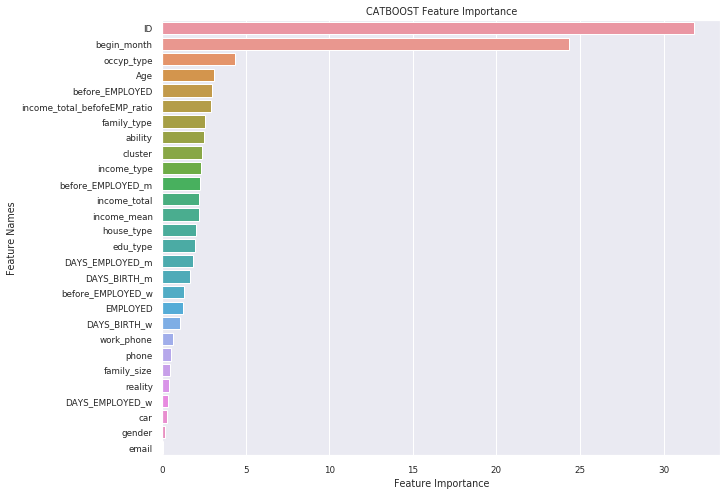

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

ÏÉàÎ°≠Í≤å Ï¢ÖÌï©Ìïú featureÏù∏ **'ID'**Ïùò Ï§ëÏöîÎèÑÍ∞Ä ÏÉÅÎãπÌûà ÎÜíÍ≤å ÎÇòÏò§Îäî Í≤ÉÏùÑ Î≥º Ïàò ÏûàÏóàÏäµÎãàÎã§.

Í∑∏ Îã§ÏùåÏùÄ **'begin_month'**Ïù¥Í≥† 3Î≤àÏß∏ featureÎ∂ÄÌÑ∞Îäî Ï§ëÏöîÎèÑÍ∞Ä 5%ÎØ∏ÎßåÏúºÎ°ú ÎßéÏù¥ Îñ®Ïñ¥ÏßÄÎäî Í≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏóàÏäµÎãàÎã§.

## üí≥ **Í≤∞Î°†**

### **Feature Enginnering**
1) Feature Ï†ÑÏ≤òÎ¶¨(ÏñëÏàò ÏπòÌôò) ‚Üí Feature Ï∂îÍ∞Ä ‚Üí Feature ÌõÑÏ≤òÎ¶¨(Ï†úÍ±∞ Î∞è LogÏ†ÅÏö©) ‚Üí ClusteringÏ†ÅÏö© ÏàúÏúºÎ°ú ÏßÑÌñâÌïòÏòÄÏäµÎãàÎã§. 

2) Feature Ï†ÑÏ≤òÎ¶¨ÏóêÏÑúÎäî Nan Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨, Family_size/ Flag_mobile Ï†úÍ±∞ Î∞è ÏùåÏàòÍ∞íÏùÑ ÏñëÏàò Í∞íÏúºÎ°ú ÏπòÌôò ÌïòÏòÄÏäµÎãàÎã§. 

3) ÏπòÌôòÎêú Í∞íÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Ï¥ù 12Í∞úÏùò FeatureÎ•º Ï∂îÍ∞ÄÌïòÏòÄÏäµÎãàÎã§. 

4) Ï∂îÍ∞ÄÌïú Feature Ï§ëÏóê Permutation Feature ImportanceÍ∞Ä Í∞ÄÏû• ÎÜíÏùÄ Î≥ÄÏàòÎäî IDÎ°ú Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞Î•º Ï≤òÎ¶¨ ÌïòÍ∏∞ ÏúÑÌïú Î≥ÄÏàòÎ°ú testÎç∞Ïù¥ÌÑ∞ÏôÄ train Îç∞Ïù¥ÌÑ∞Î•º ÎπÑÍµêÌñàÏùÑÎïå Ï§ëÎ≥µÎêòÏßÄ ÏïäÏùÄ Í∞í(Ïã†Í∑ú)Ïóê ÎåÄÌï¥ÏÑúÎäî Î™®Îëê -1Î°ú Ï≤òÎ¶¨ ÌïòÏòÄÏäµÎãàÎã§.

5) Ï∂îÍ∞ÄÌïú Îç∞Ïù¥ÌÑ∞ÏôÄ ÎπÑÍµêÌñàÏùÑ Îïå Îã§Ï§ëÍ≥µÏÑ†ÏùÑ Î≥¥Ïù¥Îäî Í∏∞Ï°¥ Feature 3Í∞ú(child_num, days_birth, days_employed)Î•º Ï†úÍ±∞ÌïòÏòÄÍ≥†, Ïù¥Î†áÍ≤å ÏÑ†Î≥ÑÎêú 27Í∞úÏùò Feature(Í∏∞Ï°¥+Ï∂îÍ∞Ä)Î•º K-means ÌÅ¥Îü¨Ïä§ÌÑ∞Ïóê Ï†ÅÏö©ÌïòÏó¨ 36Í∞úÏùò CategoryÎ•º FeatureÎ°ú Ï†ÅÏö©ÌïòÏó¨ Ï¥ù 28Í∞úÏùò FeatureÎ•º ÏÇ¨Ïö©ÌïòÏòÄÏäµÎãàÎã§.

### **Modeling**
1) Feature EngineeringÏùÑ ÌÜµÌï¥ ÏÑ†Î≥ÑÎêú 28Í∞úÏùò FeatureÎ•º Catboost Î™®Îç∏Ïóê Ï†ÅÏö©ÌïòÏòÄÍ≥† LGBM baseline Î™®Îç∏Í≥º ÎπÑÍµêÌïòÏòÄÏäµÎãàÎã§. CatboostÎäî XGBoostÏôÄ Í∞ôÏùÄ Í∑†Ìòï Ìä∏Î¶¨ Î∂ÑÌï† Î∞©Î≤ïÏùÑ ÏÇ¨Ïö© Ìï©ÎãàÎã§.

2) Ïù¥Ï†Ñ Ïä§ÌîÑÎ¶∞Ìä∏ Îì±ÏùÑ ÌÜµÌï¥ Í∞ôÏùÄ Îç∞Ïù¥ÌÑ∞Î°ú Îã§Î•∏ Î™®Îç∏Îì§ÏùÄ GridSearchCVÎ•º Ï†ÅÏö©ÌïòÏó¨ ÏµúÏ†ÅÏùò ÌååÎùºÎØ∏ÌÑ∞Î•º Ï†ÅÏö©ÌïòÏòÄÏùÑ ÎïåÏôÄ, CatBoostÎ°ú Í∏∞Î≥∏ ÌååÎùºÎØ∏ÌÑ∞Î•º ÏÇ¨Ïö©ÌïòÏòÄÏùÑ ÎïåÎ•º ÎπÑÍµêÌïòÎ©¥ CatBoostÍ∞Ä Í∞ÄÏû• Ï¢ãÏùÄ ÏÑ±Îä•ÏùÑ Î≥¥Ïó¨ Ï£ºÏóàÏäµÎãàÎã§. ÌïôÏäµ Ïãú Îç∞Ïù¥ÌÑ∞Î•º K-foldÎ•º Ïù¥Ïö©ÌïòÏó¨ Ïó¨Îü¨Í∞úÏùò train/validation setÏúºÎ°ú ÎÇòÎà†ÏÑú Ï†ÅÏö©ÌïòÏòÄÎäîÎç∞, foldÏùò ÏàòÎ•º 3Í∞úÏóêÏÑú 20Í∞ú ÍπåÏßÄ ÎèåÎ†§Î≥¥Í≥† Í∞ÄÏû• Ï¢ãÏùÄ Í≤∞Í≥ºÎ•º Î≥¥Ïó¨Ï§Ä 15Î°ú ÏÑ§Ï†ï ÌïòÏòÄÏäµÎãàÎã§.

### **Insight**
1) EDA Ïãú, targetÏóê Î∂ÑÌè¨Ïóê ÎåÄÌïú featureÎì§Ïùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏÉÅ ÎöúÎ†∑Ìïú Ï∞®Ïù¥Î•º Î≥º ÏàòÍ∞Ä ÏóÜÏóàÍ∏∞ ÎïåÎ¨∏Ïóê ÏàòÏπò Í∏∞Î∞ò Îç∞Ïù¥ÌÑ∞Ïùò Î≥ÄÌòïÏùÑ ÌÜµÌï¥ Îç∞Ïù¥ÌÑ∞Î•º Ï∂îÍ∞ÄÌïòÏó¨ ÏÑ±Îä•ÏùÑ Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÏóàÏäµÎãàÎã§. ÎòêÌïú Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ÎèÑ Ï°¥Ïû¨ÌïòÏòÄÎäîÎç∞ K-means ÌÅ¥Îü¨Ïä§ÌÑ∞Î•º ÌÜµÌï¥ ÏùºÏ†ïÎ∂ÄÎ∂Ñ Ìï¥Í≤∞Ìï† Ïàò ÏûàÏóàÏäµÎãàÎã§.

2) CatboostÏùò Í∏∞Î≥∏ ÌååÎßàÎØ∏ÌÑ∞Îßå ÏÇ¨Ïö©Ìï¥ÏÑú Í≤∞Í≥ºÍ∞Ä Ï¢ãÏùÄ Í≤ÉÏùÑ ÏÉÅÍ∏∞Ìï¥ Î≥º Îïå, ÌååÎùºÎØ∏ÌÑ∞Ïóê ÎÑàÎ¨¥ ÏãúÍ∞ÑÏùÑ Ìï†Ïï†ÌïòÏßÄ ÎßêÍ≥† Ïó¨Îü¨ Î™®Îç∏ÏùÑ Îπ†Î•¥Í≤å ÌïôÏäµ ÌõÑ Feature EngineeringÏùÑ Ï†ÅÏö©ÌïòÏó¨ ÏùòÎØ∏ ÏûàÎäî FeatureÎì§ÏùÑ Ï∞æÏïÑÎÇ¥Í±∞ÎÇò Ï∂îÍ∞ÄÌïòÎäîÍ≤å Îçî Ï¢ãÏùÄ Í≤∞Í≥ºÎ•º Î≥¥Ïó¨ Ï§ÑÍ≤ÉÏúºÎ°ú ÏÉùÍ∞ÅÎê©ÎãàÎã§.
